# Foreign Keys

# Referential integrity

**Referential Integrity** is the guarantee made by the data management process that the entitites represented in the database remain correctly associated and mutually consistent and that relationships between them remain accurate.

Referential integrity is predicated on entity integrity. 
Without entity integrity, referential integrity cannot be properly defined nor enforced.

# Foreign keys
In relational databases, referential integrity is defined and enforced by the means of *foreign keys*, which establishes a reltionship between the *child table* that contains the foreign key and the *parent table* that is referenced by the foreign key. 

A **foreign key** is a column or several columns in the child table referencing the primary key column(s) in the parent table.

In DataJoint, the foreign *always* references the primary key of the parent table and that's the only way foreign keys are used. 
However, more generally in SQL and relational theory, foreign keys can reference other sets of columns.
Such uses are esoteric and we avoid using them. 
All foreign key references in this book will reference the primary key of the parent table.

In the following example, we create a foreign key between an employee and their work title.  We first define a lookup table `Title` that lists all possible titles and the table `Employee` that containts references `Title`.

In [7]:
import datajoint as dj
schema = dj.Schema('company')


@schema
class Title(dj.Lookup):
    definition = """
    title_code  : char(8)
    ---
    full_title : varchar(120)
    """
    
    contents = [
        ("SW-Dev1", "Software Developer 1"),
        ("SW-Dev2", "Software Developer 2"),
        ("SW-Dev3", "Software Developer 3"),
        ("Web-Dev1", "Web Developer 1"),
        ("Web-Dev2", "Web Developer 2"),
        ("Web-Dev3", "Web Developer 3"),
        ("HR-Mgr", "Human Resources Manager")
    ]



@schema
class Employee(dj.Manual):
    definition = """
    person_id  :  int 
    ---
    first_name : varchar(30)
    last_name : varchar(30)
    -> Title
    """

Here the arrow `-> Title` create a foreign key from `Employee` to `Title`.

We can use the `dj.Diagram` class to visualize the relationships created by the foreign keys.

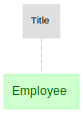

In [8]:
dj.Diagram(schema)

The parent table `Title` is above and the child table `Employee` is below.

## The Five Effects of a Foreign Key

Foreign keys enforce **referential integrity** by regulating the relationships between a **parent table** (referenced entity set) and a **child table** (dependent entity set). In addition to defining how entities relate, foreign keys also impose important constraints on data operations. 

Below are the five key effects of foreign keys:

### Effect 1. The primary key columns from the parent become embedded as foreign key columns in the child  
When a foreign key relationship is established, the **primary key** (or unique key) of the parent table becomes part of the child table’s schema. The child table includes the foreign key attribute(s) with **matching name and datatype** to ensure that each row in the child table refers to a valid parent record.

If you examine the heading of `Employee`, you will find that it now contains a `title_code` field. It will have the same data type as the 


In [6]:
Employee()

person_id,first_name,last_name,title_code



### Effect 2: Inserts into the child table are restricted unless there is a match in the parent table  
When inserting a new row into the child table, the database ensures that the foreign key value **must match a primary key** in the parent table. If no matching parent row exists, the insert is rejected, preventing **orphaned records** in the child table.

For example, let's try inserting two employees. The first will use an existing title where as the other will use a new title.

In [11]:
# This works!
Employee.insert1((1, 'Mark', 'Sommers', 'Web-Dev1'))

In [12]:
# This fails!
Employee.insert1((2, 'Brenda', 'Means', 'BizDev'))

IntegrityError: Cannot add or update a child row: a foreign key constraint fails (`company`.`employee`, CONSTRAINT `employee_ibfk_1` FOREIGN KEY (`title_code`) REFERENCES `#title` (`title_code`) ON DELETE RESTRICT ON UPDATE CASCADE)

### Effect 3. Deletes from the parent table are restricted for rows that have matching children  
A parent record cannot be deleted if it is referenced by any child records. This restriction prevents **broken relationships** between tables. The only way to delete the parent is to first delete or update the dependent child records, or to use a **cascading delete** that removes both parent and child rows.

- **Cascading Delete Option**: With cascading delete enabled, deleting a parent row automatically removes all its associated child rows.


Deleting from `Title` will generate a warning that children in `Employee` will be deleted too. Such cascading will go down many levels through the hierarchy.

In [13]:
Title.delete()

[2024-10-21 02:56:58,805][INFO]: Deleting 1 rows from `company`.`employee`
[2024-10-21 02:56:58,818][INFO]: Deleting 7 rows from `company`.`#title`
[2024-10-21 02:57:03,935][WARNING]: Deletes cancelled


7

### Effect 4. Restrict Updates to the Foreign Key and the Referenced Primary Key  
Foreign keys **restrict updates** on both the child and parent tables to maintain data consistency.

DataJoint does not support updates of primary key values since such updates have the potential for breaking down referential integrity.
Normal data manipulations are performed by deletes and inserts. However SQL and relational theory more generally supports such operations. 

- **Updates in the Parent Table**: If the primary key of a parent record is updated, all dependent child records must be updated to maintain referential integrity. However, unless **cascading updates** are configured, these updates are blocked to prevent inconsistency.

- **Updates in the Child Table**: Similarly, updating the foreign key value in a child record is restricted to ensure that the new value matches a valid parent row.

- **Cascading Update Option**: With cascading updates enabled, changes to a parent’s primary key will automatically propagate to the related child records.


### Effect 5. Create an index in the child table for fast searches on the foreign key  
To optimize performance, the database **automatically creates an index** on the foreign key column(s) in the child table. This index allows the database to efficiently find child records that refer to a specific parent row, improving query performance during joins and lookups.

# Summary  
Foreign keys ensure **referential integrity** by imposing constraints on how data is added, modified, and deleted across related tables. The five key effects are:

1. **Schema Design**: The parent’s primary key becomes part of the child table as a foreign key.  
2. **Insert Restriction**: Inserts into the child table are blocked unless a matching parent row exists.  
3. **Delete Restriction**: Deleting a parent row is blocked unless dependent child rows are handled (or cascading delete is enabled).  
4. **Update Restriction**: Updates to the primary key in the parent table and foreign key in the child table are restricted to maintain consistency, unless cascading updates are explicitly allowed.
5. **Performance Optimization**: An index on the foreign key in the child table ensures fast searches and efficient joins.  
